In [142]:
import h5py
import pandas as pd
with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split.h5') as store:
    X_cal = store.get('X_cal')
    Y_cal = store.get('Y_cal')
    X_test = store.get('X_test')
    Y_test = store.get('Y_test')


X = X_cal.values
Y = Y_cal.values

X.shape

(936, 153)

In [143]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import numpy as np


windows = [60,80,100]
R2_mean = np.zeros((len(windows),9))
Q2_mean = np.zeros((len(windows),9))
coefs = np.zeros((len(windows),9,X.shape[1]))
for ii,window_size in enumerate(windows):
    
    N_seg = X.shape[0]-window_size-5
    for latent_variables in range(1,10):
        current_time = window_size
        R2 = []
        Q2 = []
        for seg in range(N_seg):
            X_seg_cal = X[current_time-window_size:current_time,:]
            X_seg_test = X[current_time:current_time+5,:]
            Y_seg_cal = Y[current_time-window_size:current_time]
            Y_seg_test = Y[current_time:current_time+5]

            
            model = make_pipeline(StandardScaler(),PLSRegression(n_components=latent_variables))
            model.fit(X_seg_cal,Y_seg_cal)

            coefs[ii,latent_variables-1,:] = model.named_steps['plsregression'].coef_

            Y_cal_pred = model.predict(X_seg_cal)
            Y_test_pred = model.predict(X_seg_test)

            R2.append(r2_score(Y_seg_cal,Y_cal_pred))
            Q2.append(r2_score(Y_seg_test,Y_test_pred))

            current_time += 1
            

        R2_mean[ii,latent_variables-1] = np.mean(R2)
        Q2_mean[ii,latent_variables-1] = np.mean(Q2)







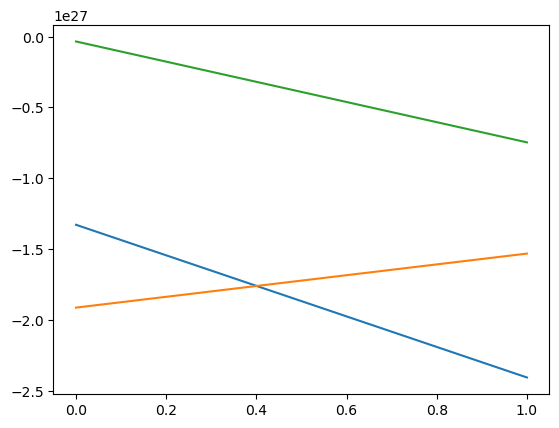

In [157]:
import matplotlib.pyplot as plt

# plt.plot(R2_mean.T)
plt.plot(Q2_mean[0:,:2].T)
# plt.ylim(-10,1.1)


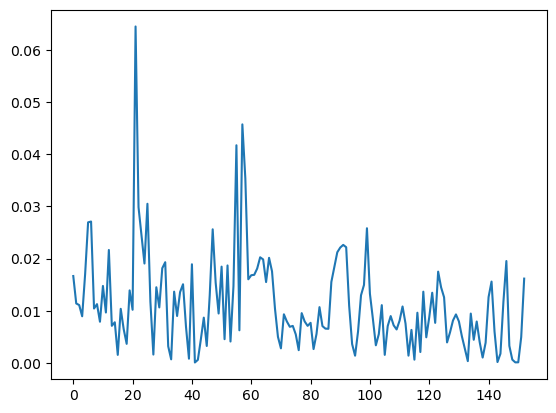

In [145]:


import seaborn as sns
save_variables = False

plt.plot(abs(coefs[:,:5,:].mean(axis=(0,1))))

coef_abs = abs(coefs[:,:5,:].mean(axis=(0,1)))

N_half = int(X.shape[1]/2)

variables = np.argsort(coef_abs)[:N_half]

if save_variables:
    np.save('variables.npy',variables)